[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/116_pl2/116_pl2.ipynb)

# Pytorch Lightning 2.0

Con la llegada de `Pytorch 2.0`, de lo cual hablamos en detalle en el post anterior, llega también la versión 2.0 de `Pytorch Lightning`, la librería que simplifica y potencia el entrenamiento de redes neuronales en `Pytorch` (entre otras cualidades). Del mismo modo que hicimos en el post anterior, este servirá como introducción a la librería para aquellos que no esten familiarizados con ella. Por otro lado, si ya la conoces, aprenderás las novedades de la versión 2.0 y repasarás los conceptos básicos.

## ¿Qué es Pytorch Lightning?

`Pytorch Lightning` es un framework de *Deep Learning*, construido por encima de `Pytorch`, que nos hace la vida más fácil a la hora de entrenar redes neuronales. Esto incluye la posibilidad de entrenar en múltiples GPUs e incluso TPUs sin ningun tipo de esfuerzo de implementación por nuestra parte, el uso de *callbacks* para realizar acciones durante el entrenamiento, la integración de *loggers* para el trackeado de experimentos, etc. Y todo ello de manera flexible y reproducible. Si bien `Pytoch Lightning` nació con esta librería, hoy en día forma parte de un ente mayor conocido como [`LightningAI`](https://lightning.ai/) que gestiona además otras librerías, como `Torchmetrics`, y además ofrece soluciones para desplegar modelos y ponerlos en producción.

Puedes instalar `Pytorch Lightning` con el siguiente comando:

```
pip install lightning
```

In [7]:
import lightning as L 

L.__version__

'2.0.0'

## Lightning Fabric

Una de las nuevas características de la versión 2.0 es la introducción de `Lightning Fabric`, un nuevo concepto que permite la adpoción progresive de `Pytoch Lightning` es nuestro código.

![fabric](https://warehouse-camo.ingress.cmh1.psfhosted.org/00031ab751d5ceb361be2b79f0549c6286f2eebc/68747470733a2f2f706c2d7075626c69632d646174612e73332e616d617a6f6e6177732e636f6d2f6173736574735f6c696768746e696e672f636f6e74696e75756d2e706e67)

Vamos a ver como podemos aplicarlo al mismo ejemplo del post anterior, en el que entramos un `Perceptrón Multicapa` para la clasificación de dígitos manuscritos con el dataset `MNIST`.	

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import torch


# mnist = fetch_openml('mnist_784', version=1)
# X, Y = mnist["data"].values.astype(float).reshape(-1, 28, 28) / 255., mnist["target"].values.astype(int)
# np.savez_compressed("mnist.npz", X=X, y=Y)

# la descarga puede tardar un rato, así que te recomiendo comentar las líneas anteriores después
# de ejecutarlas la primera vez y descomentar las siguientes para cargar los datos desde el disco

X, Y = np.load("mnist.npz")["X"], np.load("mnist.npz")["y"]

X.shape, Y.shape

((70000, 28, 28), (70000,))

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X).float()
        self.Y = torch.tensor(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]
    def collate_fn(self, batch):
        x, y = [], []
        for _x, _y in batch:
            x.append(_x)
            y.append(_y)
        return torch.stack(x).view(len(batch), -1), torch.stack(y) 
    
class Model(torch.nn.Module):
    def __init__(self, D_in=784, H=100, D_out=10):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(H, D_out)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [4]:
dataset = {
    "train": Dataset(X[:60000], Y[:60000]),
    "val": Dataset(X[60000:], Y[60000:])
}
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, collate_fn=dataset['train'].collate_fn),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=100, collate_fn=dataset['val'].collate_fn)
}
model = Model(784, 100, 10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5
for e in range(1, epochs+1):
    print(f"epoch: {e}/{epochs}")
    model.train()
    for batch_ix, (x, y) in enumerate(dataloader['train']):
        optimizer.zero_grad()           
        outputs = model(x)              
        loss = criterion(outputs, y)    
        loss.backward()                 
        optimizer.step()                
        if batch_ix % 100 == 0:
            loss, current = loss.item(), (batch_ix + 1) * len(x)
            print(f"loss: {loss:.4f} [{current:>5d}/{len(dataset['train']):>5d}]")
    model.eval()                
    val_loss, val_acc = [], []
    with torch.no_grad():
        for batch_ix, (x, y) in enumerate(dataloader['val']):
            outputs = model(x)              
            loss = criterion(outputs, y)    
            val_loss.append(loss.item())
            val_acc.append((outputs.argmax(1) == y).float().mean().item())
    print(f"val_loss: {np.mean(val_loss):.4f} val_acc: {np.mean(val_acc):.4f}")

epoch: 1/5
loss: 2.2954 [  100/60000]
loss: 0.4793 [10100/60000]
loss: 0.4799 [20100/60000]
loss: 0.3402 [30100/60000]
loss: 0.2535 [40100/60000]
loss: 0.2809 [50100/60000]
val_loss: 0.2398 val_acc: 0.9279
epoch: 2/5
loss: 0.1961 [  100/60000]
loss: 0.2457 [10100/60000]
loss: 0.2592 [20100/60000]
loss: 0.2194 [30100/60000]
loss: 0.1613 [40100/60000]
loss: 0.1630 [50100/60000]
val_loss: 0.1689 val_acc: 0.9492
epoch: 3/5
loss: 0.1329 [  100/60000]
loss: 0.1834 [10100/60000]
loss: 0.1938 [20100/60000]
loss: 0.1862 [30100/60000]
loss: 0.1216 [40100/60000]
loss: 0.1034 [50100/60000]
val_loss: 0.1372 val_acc: 0.9593
epoch: 4/5
loss: 0.1079 [  100/60000]
loss: 0.1417 [10100/60000]
loss: 0.1558 [20100/60000]
loss: 0.1591 [30100/60000]
loss: 0.1014 [40100/60000]
loss: 0.0776 [50100/60000]
val_loss: 0.1192 val_acc: 0.9644
epoch: 5/5
loss: 0.0897 [  100/60000]
loss: 0.1178 [10100/60000]
loss: 0.1317 [20100/60000]
loss: 0.1314 [30100/60000]
loss: 0.0863 [40100/60000]
loss: 0.0625 [50100/60000]
val

### Aceleradores

Lo primero que podemos hacer es ceder el control a `Fabric` sobre la infraestructura de entrenamiento. De esta manera, podremos entrenar en múltiples `GPUs` y otros aceleradores sin tener que preocuparnos por la implementación. En este post ejecturé los ejemplos en 2 `GPUs`, por lo que si no tienes acceso a este tipo de hardware, ejecuta el código en una sola `GPU` o en la `CPU`.

In [20]:
fabric = L.Fabric(accelerator="cuda", devices=2, strategy='dp', precision=16) # 2 gpus con estrategia data parallel y mixed precision
fabric.launch()

Using 16-bit Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [21]:
dataloader = {
    'train': fabric.setup_dataloaders(torch.utils.data.DataLoader(dataset['train'], batch_size=100, collate_fn=dataset['train'].collate_fn)),
    'val': fabric.setup_dataloaders(torch.utils.data.DataLoader(dataset['val'], batch_size=100, collate_fn=dataset['val'].collate_fn))
}
model = Model(784, 100, 10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
model, optimizer = fabric.setup(model, optimizer)
epochs = 5
for e in range(1, epochs+1):
    print(f"epoch: {e}/{epochs}")
    model.train()
    for batch_ix, (x, y) in enumerate(dataloader['train']):
        optimizer.zero_grad()           
        outputs = model(x)              
        loss = criterion(outputs, y)    
        fabric.backward(loss)                 
        optimizer.step()                
        if batch_ix % 100 == 0:
            loss, current = loss.item(), (batch_ix + 1) * len(x)
            print(f"loss: {loss:.4f} [{current:>5d}/{len(dataset['train']):>5d}]")
    model.eval()                
    val_loss, val_acc = [], []
    with torch.no_grad():
        for batch_ix, (x, y) in enumerate(dataloader['val']):
            outputs = model(x)              
            loss = criterion(outputs, y)    
            val_loss.append(loss.item())
            val_acc.append((outputs.argmax(1) == y).float().mean().item())
    print(f"val_loss: {np.mean(val_loss):.4f} val_acc: {np.mean(val_acc):.4f}")

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


epoch: 1/5
loss: 2.3244 [  100/60000]
loss: 0.4593 [10100/60000]
loss: 0.4683 [20100/60000]
loss: 0.3326 [30100/60000]
loss: 0.2442 [40100/60000]
loss: 0.2686 [50100/60000]
val_loss: 0.2336 val_acc: 0.9313
epoch: 2/5
loss: 0.1946 [  100/60000]
loss: 0.2204 [10100/60000]
loss: 0.2522 [20100/60000]
loss: 0.2161 [30100/60000]
loss: 0.1605 [40100/60000]
loss: 0.1673 [50100/60000]
val_loss: 0.1659 val_acc: 0.9509
epoch: 3/5
loss: 0.1358 [  100/60000]
loss: 0.1720 [10100/60000]
loss: 0.2004 [20100/60000]
loss: 0.1922 [30100/60000]
loss: 0.1207 [40100/60000]
loss: 0.1273 [50100/60000]
val_loss: 0.1328 val_acc: 0.9604
epoch: 4/5
loss: 0.1050 [  100/60000]
loss: 0.1318 [10100/60000]
loss: 0.1613 [20100/60000]
loss: 0.1783 [30100/60000]
loss: 0.0953 [40100/60000]
loss: 0.1141 [50100/60000]
val_loss: 0.1143 val_acc: 0.9658
epoch: 5/5
loss: 0.0854 [  100/60000]
loss: 0.1077 [10100/60000]
loss: 0.1338 [20100/60000]
loss: 0.1668 [30100/60000]
loss: 0.0802 [40100/60000]
loss: 0.1014 [50100/60000]
val

### El `LightningModule`

El siguiente paso para sacar todavía más partido a `Fabric` es utilizar `LightningModule` como base para nuestros modelos. 

In [26]:
class LitModel(L.LightningModule):
    def __init__(self, D_in=784, H=100, D_out=10):
        super().__init__()
        self.model = Model(D_in, H, D_out)
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = lambda y_hat, y: (y_hat.argmax(1) == y).float().mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        acc = self.accuracy(y_hat, y)
        return loss, acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset['train'], batch_size=100, collate_fn=dataset['train'].collate_fn)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(dataset['val'], batch_size=100, collate_fn=dataset['val'].collate_fn)

    def log(self, batch_ix, loss, x, dataset): # mi propio hook para loggear
        if batch_ix % 100 == 0:
            loss, current = loss.item(), (batch_ix + 1) * len(x)
            print(f"loss: {loss:.4f} [{current:>5d}/{len(dataset):>5d}]")

In [31]:
fabric = L.Fabric(accelerator="cuda", devices=2, strategy='dp', precision=16) # 2 gpus con estrategia data parallel y mixed precision
model = LitModel(784, 100, 10)
optimizer = model.configure_optimizers()
model, optimizer = fabric.setup(model, optimizer)
dataloader = {
    'train': fabric.setup_dataloaders(model.train_dataloader()),
    'val': fabric.setup_dataloaders(model.val_dataloader())
}
epochs = 5
for e in range(1, epochs+1):
    print(f"epoch: {e}/{epochs}")
    model.train()
    for batch_ix, batch in enumerate(dataloader['train']):
        optimizer.zero_grad()           
        loss = model.training_step(batch, batch_ix)   
        fabric.backward(loss)                 
        optimizer.step()  
        model.log(batch_ix, loss, x, dataset['train'])              
    model.eval()                
    val_loss, val_acc = [], []
    with torch.no_grad():
        for batch_ix, batch in enumerate(dataloader['val']):
            loss, acc = model.validation_step(batch, batch_ix)
            val_loss.append(loss.item())
            val_acc.append(acc)
    print(f"val_loss: {np.mean(val_loss):.4f} val_acc: {np.mean(val_acc):.4f}")

/home/juan/miniconda3/envs/pt2/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16-bit Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


epoch: 1/5
loss: 2.3130 [  100/60000]
loss: 0.4688 [10100/60000]
loss: 0.4964 [20100/60000]
loss: 0.3415 [30100/60000]
loss: 0.2553 [40100/60000]
loss: 0.2702 [50100/60000]
val_loss: 0.2400 val_acc: 0.1100
epoch: 2/5
loss: 0.2138 [  100/60000]
loss: 0.2246 [10100/60000]
loss: 0.2785 [20100/60000]
loss: 0.2219 [30100/60000]
loss: 0.1643 [40100/60000]
loss: 0.1474 [50100/60000]
val_loss: 0.1746 val_acc: 0.1100
epoch: 3/5
loss: 0.1484 [  100/60000]
loss: 0.1834 [10100/60000]
loss: 0.2060 [20100/60000]
loss: 0.1783 [30100/60000]
loss: 0.1213 [40100/60000]
loss: 0.1023 [50100/60000]
val_loss: 0.1406 val_acc: 0.1100
epoch: 4/5
loss: 0.1179 [  100/60000]
loss: 0.1536 [10100/60000]
loss: 0.1682 [20100/60000]
loss: 0.1597 [30100/60000]
loss: 0.0920 [40100/60000]
loss: 0.0769 [50100/60000]
val_loss: 0.1225 val_acc: 0.1100
epoch: 5/5
loss: 0.0984 [  100/60000]
loss: 0.1231 [10100/60000]
loss: 0.1368 [20100/60000]
loss: 0.1501 [30100/60000]
loss: 0.0751 [40100/60000]
loss: 0.0608 [50100/60000]
val

De esta manera desacolpamos la lógica de entrenamiento de la lógica de la arquitectura de la red, muy apropiado si queremos probar distintos modelos en un mismo problema. Además, nos permite usar los [hooks](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#hooks) por defecto o implementar los nuestros propios. !Muy interesante!

### *Logging*

Una parte esencial de cualquier entrenamiento consiste en *logear* los resultados obtenidos. Esto nos permite comparar distintos experimentos y ver como evoluciona nuestro modelo. `Fabric` nos ofrece diferentes *loggers*

In [56]:
from lightning.fabric.loggers import CSVLogger # o Tensorboard
from tqdm import tqdm

logger = CSVLogger('logs', 'MNIST', version=0)
fabric = L.Fabric(accelerator="cuda", devices=1, precision=16, loggers=logger) 
model = LitModel(784, 100, 10)
optimizer = model.configure_optimizers()
model, optimizer = fabric.setup(model, optimizer)
dataloader = {
    'train': fabric.setup_dataloaders(model.train_dataloader()),
    'val': fabric.setup_dataloaders(model.val_dataloader())
}
epochs = 20
pbar = tqdm(range(1, epochs+1))
for e in pbar:
    model.train()
    train_loss = []
    for batch_ix, batch in enumerate(dataloader['train']):
        optimizer.zero_grad()           
        loss = model.training_step(batch, batch_ix)   
        fabric.backward(loss)                 
        optimizer.step()  
        train_loss.append(loss.item())
    model.eval()                
    val_loss, val_acc = [], []
    with torch.no_grad():
        for batch_ix, batch in enumerate(dataloader['val']):
            loss, acc = model.validation_step(batch, batch_ix)
            val_loss.append(loss.item())
            val_acc.append(acc.item())
    pbar.set_description(f"loss {np.mean(train_loss):.4f} val_loss: {np.mean(val_loss):.4f} val_acc: {np.mean(val_acc):.4f}")
    fabric.log_dict({'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc), 'epoch': e, 'train_loss': np.mean(train_loss)})
logger.finalize("success")

/home/juan/miniconda3/envs/pt2/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16-bit Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
loss 0.4244 val_loss: 0.2434 val_acc: 0.9292:   0%|          | 0/20 [00:01<?, ?it/s]/home/juan/miniconda3/envs/pt2/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/MNIST/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are sav

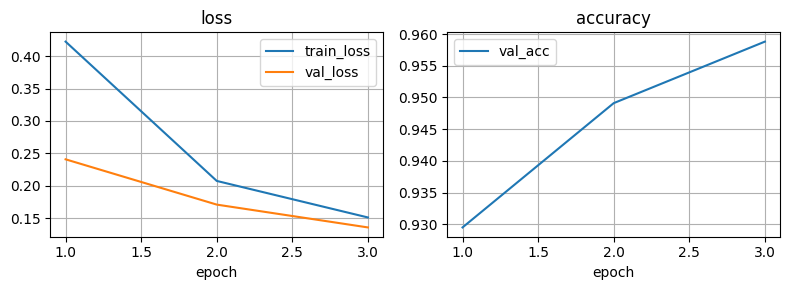

In [87]:
import pandas as pd 
import matplotlib.pyplot as plt

def plot_logs(df):
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121)
    df.plot(x='epoch', y=['train_loss', 'val_loss'], grid=True, title='loss', ax=ax)
    ax = fig.add_subplot(122)
    df.plot(x='epoch', y=['val_acc'], grid=True, title='accuracy', ax=ax)
    plt.tight_layout()
    plt.show()

df = pd.read_csv('logs/MNIST/version_0/metrics.csv')
plot_logs(df)

### *Checkpoints*

Los checkpoints son una forma de guardar el estado de nuestro modelo en un momento determinado. Esto nos permite continuar el entrenamiento en un momento posterior, o incluso cargar el modelo para hacer inferencia. 

In [83]:
def train(epochs=10, resume=None, load=None, version=0):
    logger = CSVLogger('logs', 'MNIST', version=version)
    fabric = L.Fabric(accelerator="cuda", devices=1, precision=16, loggers=logger) 
    model = LitModel(784, 100, 10)
    optimizer = model.configure_optimizers()
    model, optimizer = fabric.setup(model, optimizer)
    dataloader = {
        'train': fabric.setup_dataloaders(model.train_dataloader()),
        'val': fabric.setup_dataloaders(model.val_dataloader())
    }
    e0 = 1
    if resume: # cargamos todo para seguir entrenando
        reminder = fabric.load(resume, {'model': model, 'optimizer': optimizer})
        e0 = reminder['epoch'] + 1
    if load: # cargamos solo el modelo
        reminder = fabric.load(load, {'model': model})
    pbar = tqdm(range(e0, epochs+1))
    for e in pbar:
        model.train()
        train_loss = []
        for batch_ix, batch in enumerate(dataloader['train']):
            optimizer.zero_grad()           
            loss = model.training_step(batch, batch_ix)   
            fabric.backward(loss)                 
            optimizer.step()  
            train_loss.append(loss.item())
        model.eval()                
        val_loss, val_acc = [], []
        with torch.no_grad():
            for batch_ix, batch in enumerate(dataloader['val']):
                loss, acc = model.validation_step(batch, batch_ix)
                val_loss.append(loss.item())
                val_acc.append(acc.item())
        pbar.set_description(f"loss {np.mean(train_loss):.4f} val_loss: {np.mean(val_loss):.4f} val_acc: {np.mean(val_acc):.4f}")
        fabric.log_dict({'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc), 'epoch': e, 'train_loss': np.mean(train_loss)})
        fabric.save('checkpoints/MNIST.ckpt', {
            'epoch': e,
            'model': model,
            'optimizer': optimizer
        })
    logger.finalize("success")

# entrenamos 3 epochs
train(3)

# cargamos el checkpoint para entrenar 3 más (util si se interrumpe el entrenamiento)
train(6, resume='checkpoints/MNIST.ckpt', version=1)

# cargamos el checkpoint para entrenar desde 0 (util para reentrenar un modelo)
train(5, load='checkpoints/MNIST.ckpt', version=2)


Using 16-bit Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
loss 0.1513 val_loss: 0.1359 val_acc: 0.9588: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]
Using 16-bit Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
loss 0.0755 val_loss: 0.0964 val_acc: 0.9703: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it

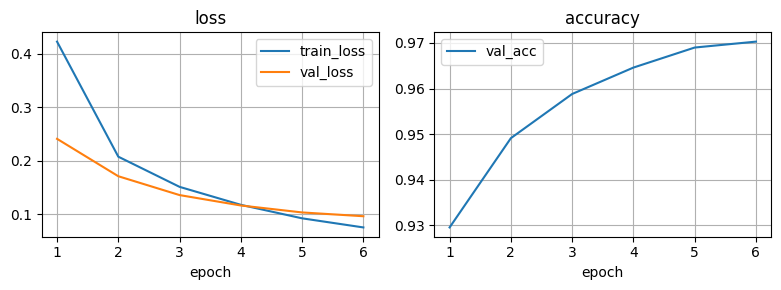

In [88]:
df1 = pd.read_csv('logs/MNIST/version_0/metrics.csv')
df2 = pd.read_csv('logs/MNIST/version_1/metrics.csv')
df = pd.concat([df1, df2])
plot_logs(df)

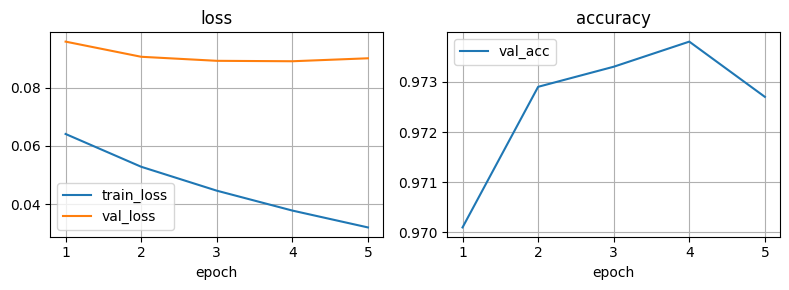

In [90]:
plot_logs(pd.read_csv('logs/MNIST/version_2/metrics.csv'))

### Plantilla de entrenamiento

Con toda esta funcionalidad que nos ofrece `Fabric` podemos simplificar el código de entrenamiento a una plantilla que podemos reusar en distintos problemas. Puedes encontrarla en el siguiente [enlace](https://github.com/Lightning-AI/lightning/blob/master/examples/fabric/build_your_own_trainer/trainer.py), aunque llegado el caso quizás es mejor que te plantees usar directamente `Pytorch Lightning`, y su `Trainer`, en lugar de `Fabric`.

## Pytorch Lightning

Si bien `Fabric` nos permite vitaminar nuestro código `Pytorch`, `Pytorch Lightning` nos ofrece una solución más completa. Si tienes una base de código extensa en `Pytorch` y quieres, por ejemplo, entrenar tus modelos en varias `GPUs` sin tener que implementar esta funcionalidad, `Fabric` es una solución adecuada. Si estas empezando un proyecto desde cero y tienes claro que quieres usar `Lightning`, entonces `Pytorch Lightning` es mi recomendación. 

El primer elemento que debes conocer es el `LightningModule`, que ya hemos visto antes. En esta clase organizaremos nuestro código para que luego sea ejecutado por el `Trainer`.

In [103]:
class LitModel(L.LightningModule):
    def __init__(self, D_in=784, H=100, D_out=10):
        super().__init__()
        self.model = Model(D_in, H, D_out)
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = lambda y_hat, y: (y_hat.argmax(1) == y).float().mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('loss', loss, prog_bar=True) # logear en la barra de progreso
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    
    # aquí no hay dataloaders !!!

In [102]:
dataset = {
    "train": Dataset(X[:60000], Y[:60000]),
    "val": Dataset(X[60000:], Y[60000:])
}
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, collate_fn=dataset['train'].collate_fn),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=100, collate_fn=dataset['val'].collate_fn)
}

modelo = LitModel()

trainer = L.Trainer(
    accelerator="cuda", 
    devices=1,              # podemos usar más de 1 GPU
    precision=16, 
    max_epochs=10
)

trainer.fit(modelo, dataloader['train'], dataloader['val'])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type             | Params
-------------------------------------------
0 | model | Model            | 79.5 K
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Como puedes vera, el `Trainer` nos abstrae toda la lógica de entrenamiento (que gracias a la sección anterior puedes entender lo que está haciendo por dentro) además de darnos información sobre nuestro modelo y una bonita barra de progreso. Como puedes esperar, también podremos usar la funcionalidad de `callbacks` y `loggers` que ya hemos visto anteriormente.

In [ ]:
from L.checkpoint import ModelCheckpoint

modelo = LitModel()

trainer = L.Trainer(
    accelerator="cuda", 
    devices=1,  
    precision=16, 
    max_epochs=10,
    logger=CSVLogger('logs', 'MNIST', version=3),
    checkpoint_callback=ModelCheckpoint('checkpoints', 'MNIST', save_top_k=1, verbose=True, monitor='val_acc', mode='max')
)

trainer.fit(modelo, dataloader['train'], dataloader['val'])

Otra caracterísitca interesante es la de poder llevar a cabo entrenamientos reproducibles (es decir, que siempre nos darán el mismo resultado siempre y cuando no cambiemos ningún parámetro). 

In [ ]:
from lightning import seed_everything

seed_everything(42, workers=True)

trainer = L.Trainer(
    accelerator="cuda", 
    devices=1, 
    precision=16, 
    max_epochs=10,
    deterministic=True,
    logger=CSVLogger('logs', 'MNIST', version=3),
    checkpoint_callback=ModelCheckpoint('checkpoints', 'MNIST', save_top_k=1, verbose=True, monitor='val_acc', mode='max')
)

trainer.fit(modelo, dataloader['train'], dataloader['val'])

Te animo a explorar todas las diferentes opciones del `Trainer` en la [documentación](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-flags).

Otro concepto interesante es el del `LightningDataModule`, que nos permite encapsular la lógica de carga de datos. Esto nos permite reutilizar el mismo módulo para distintos problemas.

In [115]:
import torchvision
from torchmetrics import Accuracy

class MNISTDataModule(L.LightningDataModule):
    def __init__(self, path = '../data', batch_size = 64):
        super().__init__()
        self.path = path
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.mnist_train = torchvision.datasets.MNIST(
            self.path, train=True, download=True, transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                ])
          )
        self.mnist_val = torchvision.datasets.MNIST(
            self.path, train=False, download=True, transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                ])
          )
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=4, pin_memory=True)
    
class MNISTModel(L.LightningModule):
    def __init__(self, D_in=784, H=100, D_out=10):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out)
        )
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=D_out)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('loss', loss, prog_bar=True) 
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [116]:
datamodule = MNISTDataModule(batch_size=1000)
modelo = MNISTModel()

trainer = L.Trainer(
    accelerator="cuda", 
    devices=1,              
    precision=16, 
    max_epochs=10
)

trainer.fit(modelo, datamodule)

/home/juan/miniconda3/envs/pt2/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | Sequential         | 79.5 K
1 | loss     | Cro

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
